<div style="text-align: center; font-size: 40px; font-weight: bold; color: hotpink;">
     Feature Engineering With Diabeties
</div>

In [1]:
!pip install missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
df = pd.read_csv("/kaggle/input/diabeties-dataset/diabetes.csv")

In [3]:
def quick_summary(dataframe, head=15):
    print("##################### HEAD #####################")
    print(dataframe .head(head))
    print("##################### TAIL #####################")
    print(dataframe.tail(head))
    print("##################### SHAPE #####################")
    print(dataframe.shape)
    print("##################### INFO #####################")
    print(dataframe.info())
    print("##################### MISSING VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### QUANTILES #####################")
    print(dataframe.describe().T)
quick_summary(df)


##################### HEAD #####################
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0             6      148             72             35        0 33.600                     0.627   50        1
1             1       85             66             29        0 26.600                     0.351   31        0
2             8      183             64              0        0 23.300                     0.672   32        1
3             1       89             66             23       94 28.100                     0.167   21        0
4             0      137             40             35      168 43.100                     2.288   33        1
5             5      116             74              0        0 25.600                     0.201   30        0
6             3       78             50             32       88 31.000                     0.248   26        1
7            10      115              0              0        0

In [4]:
df.columns = [col.upper() for col in df.columns]

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Provides the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numeric appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Threshold value for numeric but categorical variables
        car_th: int, optinal
                Threshold for categorical but not cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                categorical but cardinal list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable count 
        num_but_cat is included in cat_cols
        3 lists that is returned are equal to the total variable count: cat_cols + num_cols + cat_but_car = total variable count

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 769
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


         OUTCOME  Ratio
OUTCOME                
0            500 65.020
1            269 34.980
##########################################


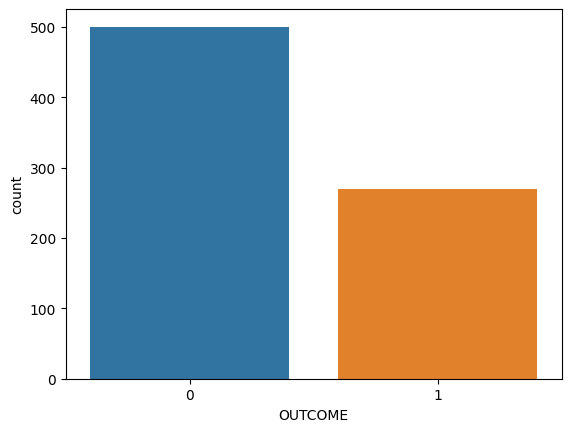

In [6]:
def cat_summary(dataframe, categorical_col, plot=False):
    print(pd.DataFrame({categorical_col: dataframe[categorical_col].value_counts(),
    "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=categorical_col, data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   769.000
mean      3.840
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: PREGNANCIES, dtype: float64


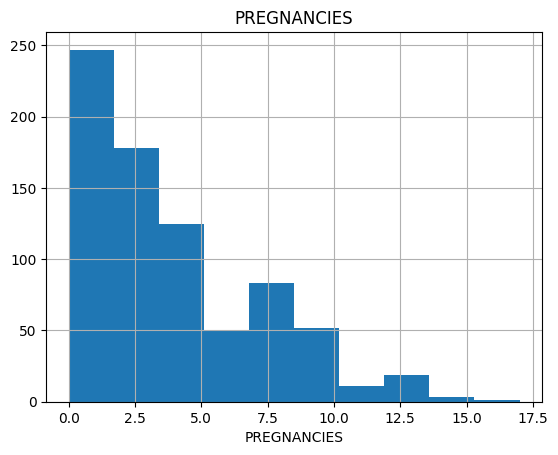

count   769.000
mean    120.897
std      31.952
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: GLUCOSE, dtype: float64


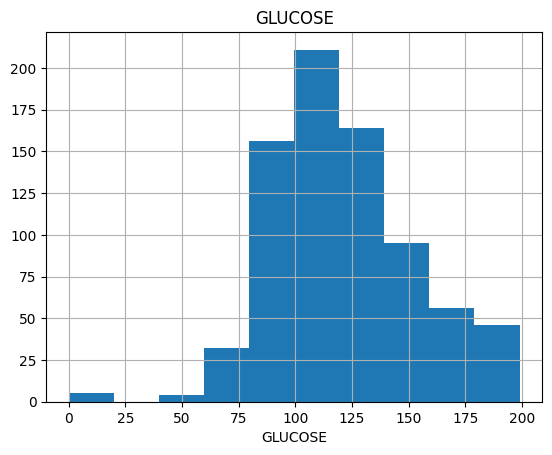

count   769.000
mean     69.116
std      19.345
min       0.000
5%       38.800
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BLOODPRESSURE, dtype: float64


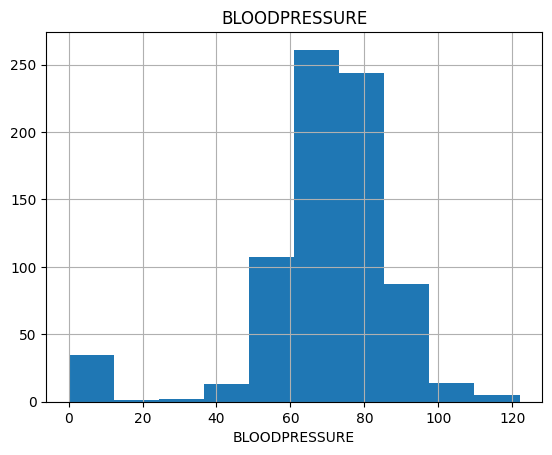

count   769.000
mean     20.510
std      15.959
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.000
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.320
max      99.000
Name: SKINTHICKNESS, dtype: float64


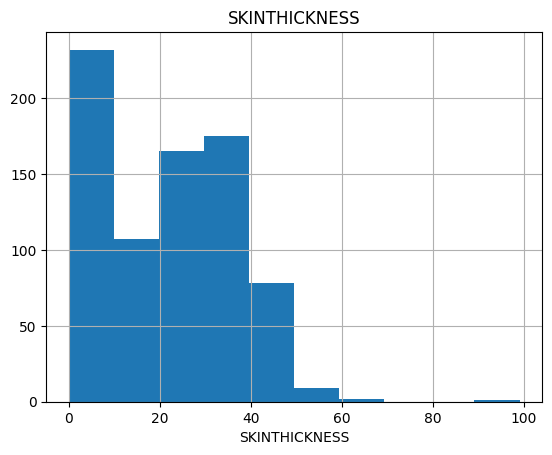

count   769.000
mean     79.697
std     115.204
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      29.000
60%      71.800
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.600
max     846.000
Name: INSULIN, dtype: float64


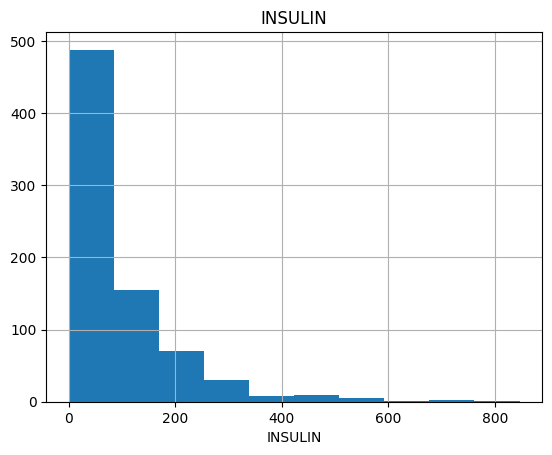

count   769.000
mean     31.998
std       7.881
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.500
80%      37.800
90%      41.500
95%      44.380
99%      50.736
max      67.100
Name: BMI, dtype: float64


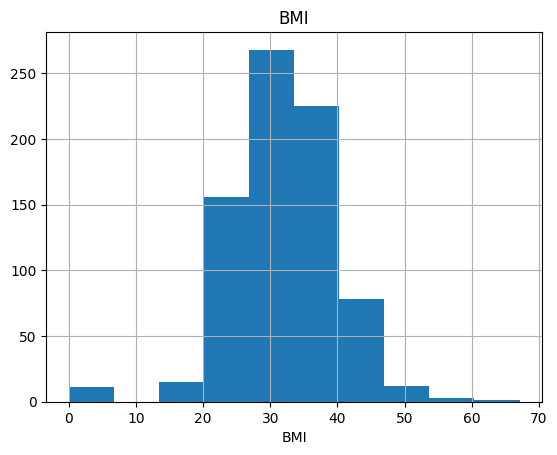

count   769.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.220
30%       0.259
40%       0.302
50%       0.371
60%       0.454
70%       0.563
80%       0.687
90%       0.878
95%       1.132
99%       1.698
max       2.420
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


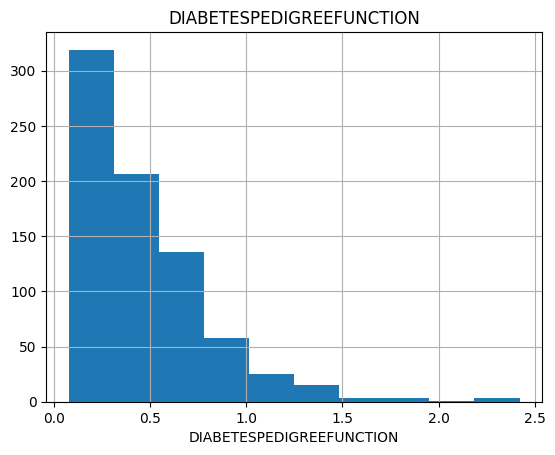

count   769.000
mean     33.269
std      11.779
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      43.000
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: AGE, dtype: float64


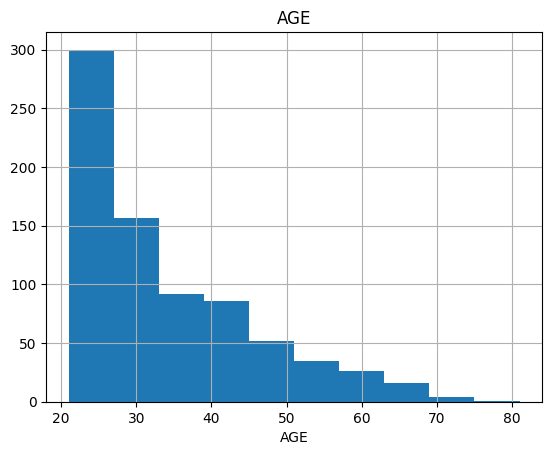

In [7]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [8]:
def target_summary_with_num(dataframe, target, numerical_col):
   print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
   target_summary_with_num(df, "OUTCOME", col)


         PREGNANCIES
OUTCOME             
0              3.298
1              4.848


         GLUCOSE
OUTCOME         
0        109.980
1        141.190


         BLOODPRESSURE
OUTCOME               
0               68.184
1               70.848


         SKINTHICKNESS
OUTCOME               
0               19.664
1               22.082


         INSULIN
OUTCOME         
0         68.792
1         99.967


           BMI
OUTCOME       
0       30.304
1       35.147


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                           0.430
1                           0.549


           AGE
OUTCOME       
0       31.190
1       37.134




In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,769.000,3.840,3.370,0.000,1.000,3.000,6.000,17.000
GLUCOSE,769.000,120.897,31.952,0.000,99.000,117.000,140.000,199.000
BLOODPRESSURE,769.000,69.116,19.345,0.000,62.000,72.000,80.000,122.000
SKINTHICKNESS,769.000,20.510,15.959,0.000,0.000,23.000,32.000,99.000
INSULIN,769.000,79.697,115.204,0.000,0.000,29.000,127.000,846.000
BMI,769.000,31.998,7.881,0.000,27.300,32.000,36.600,67.100
DIABETESPEDIGREEFUNCTION,769.000,0.472,0.331,0.078,0.244,0.371,0.626,2.420
AGE,769.000,33.269,11.779,21.000,24.000,29.000,41.000,81.000
OUTCOME,769.000,0.350,0.477,0.000,0.000,0.000,1.000,1.000


In [10]:
#Bagimli degisken OUTCOME
y = df["OUTCOME"]

#Bagimsiz degiskenler PasssengerId ve Survived disindakiler
X = df.drop(["OUTCOME"], axis=1)

#modeli 2'ye boleriz -train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

#kutuphaneyi import ederiz
from sklearn.ensemble import RandomForestClassifier

#model kurariz
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7445887445887446

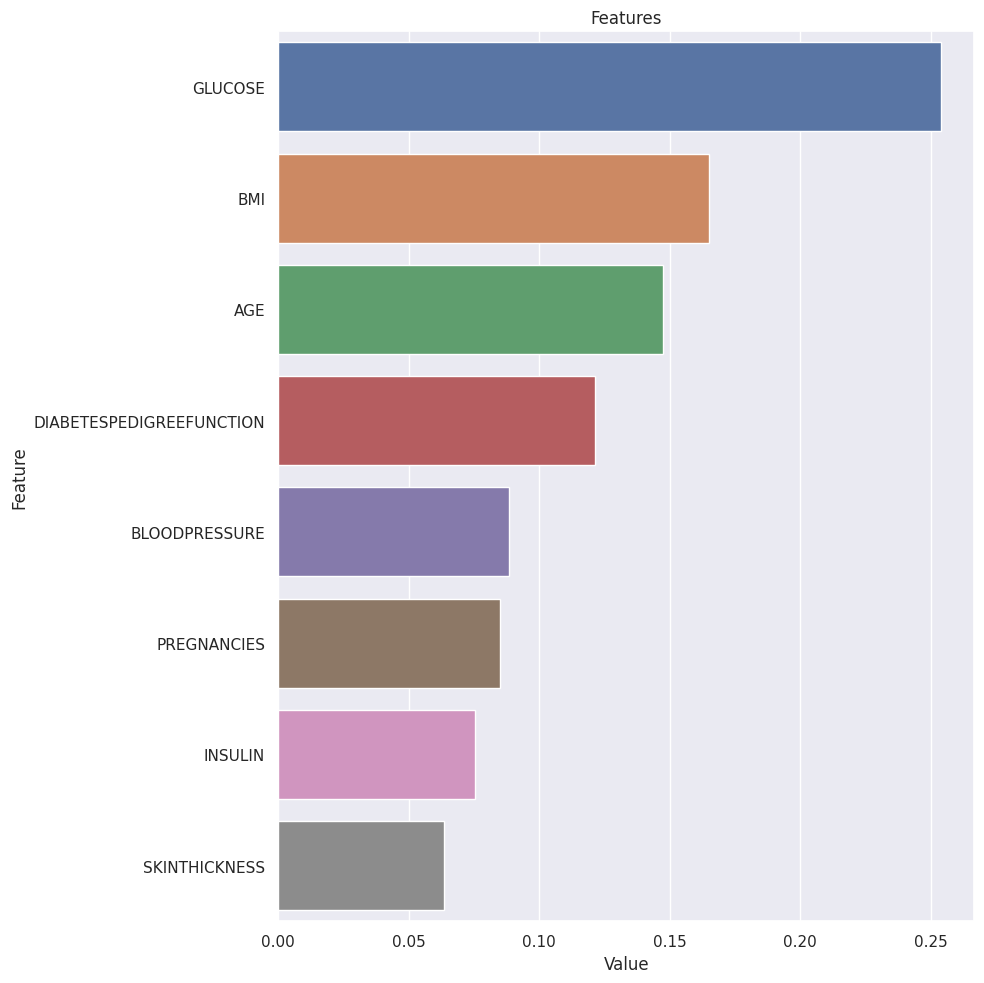

In [11]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

In [12]:
# def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
#     quartile1 = dataframe[col_name].quantile(q1)
#     quartile3 = dataframe[col_name].quantile(q3)
#     interquantile_range = quartile3 - quartile1
#     up_limit = quartile3 + 1.5 * interquantile_range
#     low_limit = quartile1 - 1.5 * interquantile_range
#     return low_limit, up_limit


# def replace_with_thresholds(dataframe, variable):
#     low_limit, up_limit = outlier_thresholds(dataframe, variable)
#     dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
#     dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
# def check_outlier(dataframe, col_name):
#     low_limit, up_limit = outlier_thresholds(dataframe, col_name)
#     if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
#         return True
#     else:
#         return False


In [13]:
# for col in num_cols:
#     print(col, check_outlier(df, col))

In [14]:
# for col in num_cols:
#     replace_with_thresholds(df, col)

In [15]:
# for col in num_cols:
#     print(col, check_outlier(df, col))

In [16]:
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [17]:
def check_zeros(dataframe, col_name):
    count_zeros = dataframe[dataframe[col_name] == 0].shape[0]
    print("##################### Zeros #####################")
    print(f"{col_name}:  {count_zeros}")


for col in df.columns:
    check_zeros(df, col)

##################### Zeros #####################
PREGNANCIES:  112
##################### Zeros #####################
GLUCOSE:  5
##################### Zeros #####################
BLOODPRESSURE:  35
##################### Zeros #####################
SKINTHICKNESS:  228
##################### Zeros #####################
INSULIN:  374
##################### Zeros #####################
BMI:  11
##################### Zeros #####################
DIABETESPEDIGREEFUNCTION:  0
##################### Zeros #####################
AGE:  0
##################### Zeros #####################
OUTCOME:  500


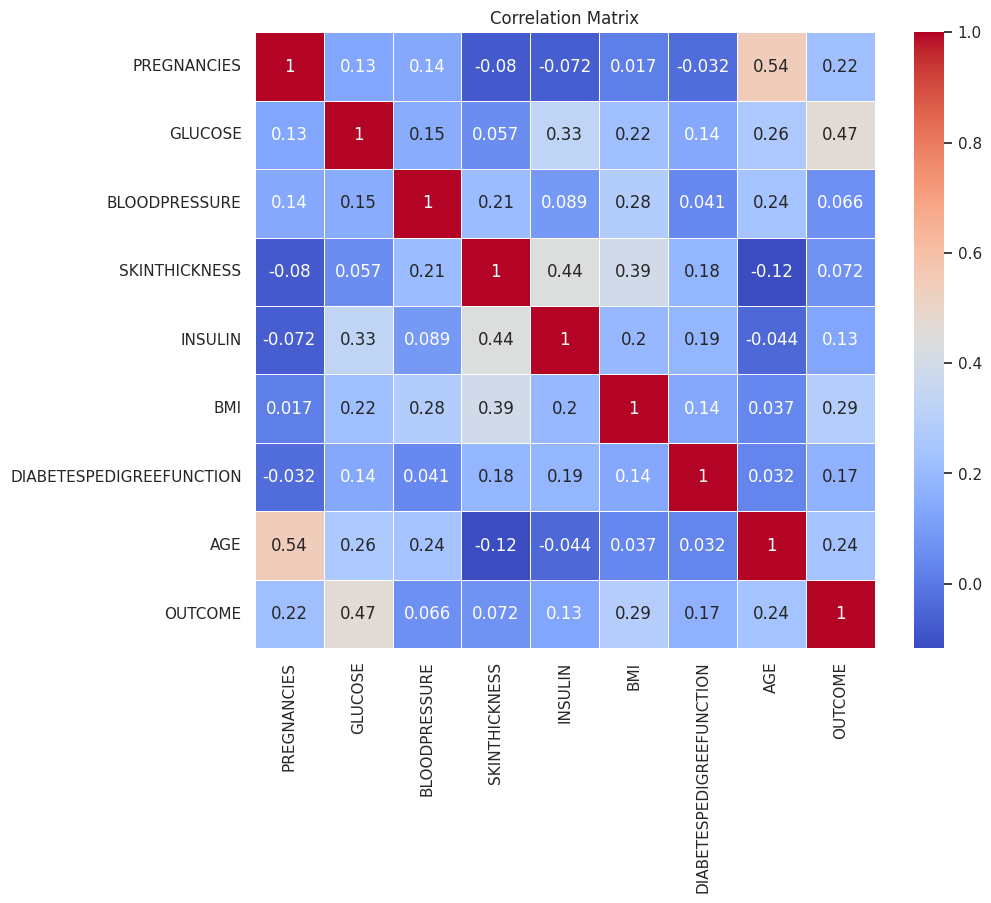

In [18]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [19]:
df[["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]] = df[["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]].replace(0, np.NaN)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [20]:
df.isnull().sum()

PREGNANCIES                   0
GLUCOSE                       5
BLOODPRESSURE                35
SKINTHICKNESS               228
INSULIN                     374
BMI                          11
DIABETESPEDIGREEFUNCTION      0
AGE                           0
OUTCOME                       0
dtype: int64

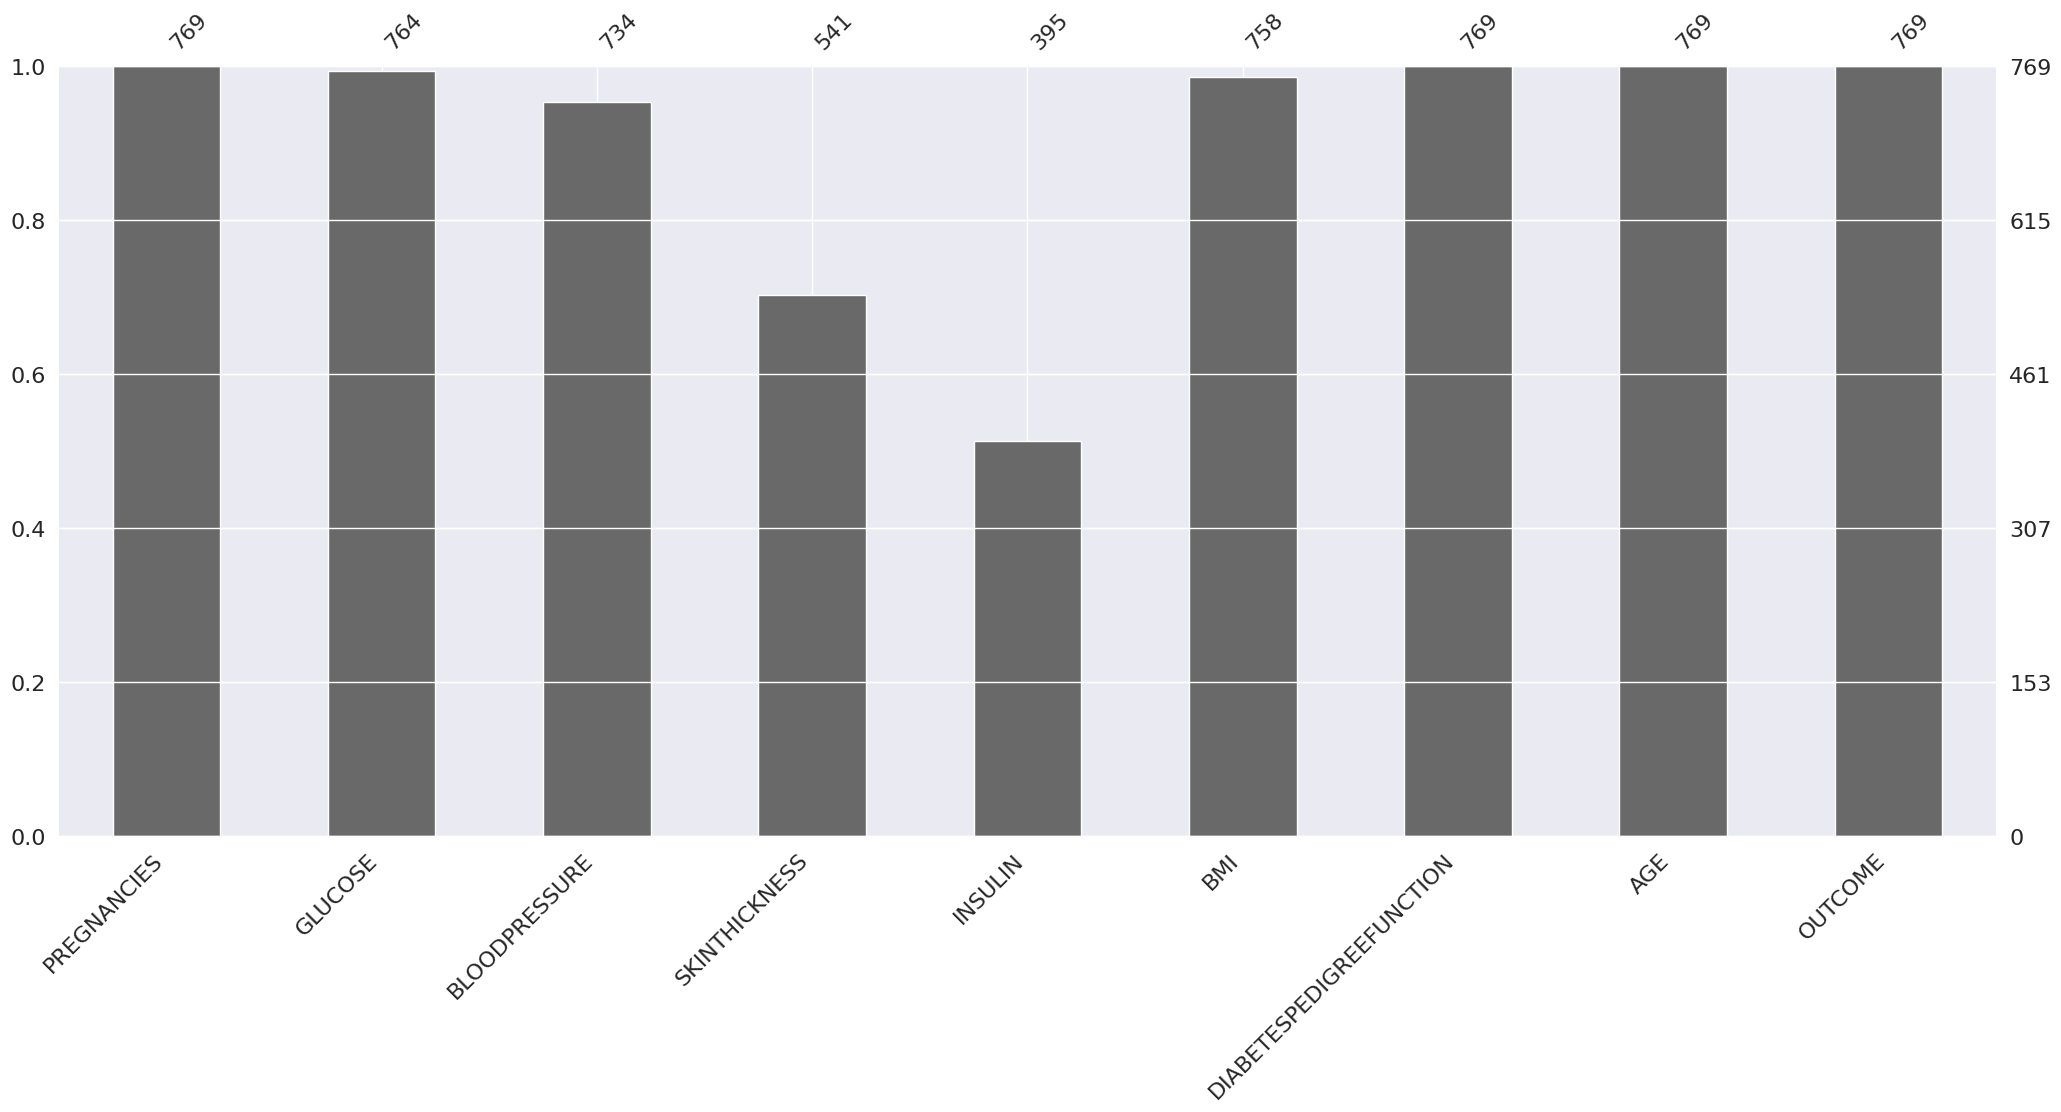

In [21]:
msno.bar(df)
plt.show()

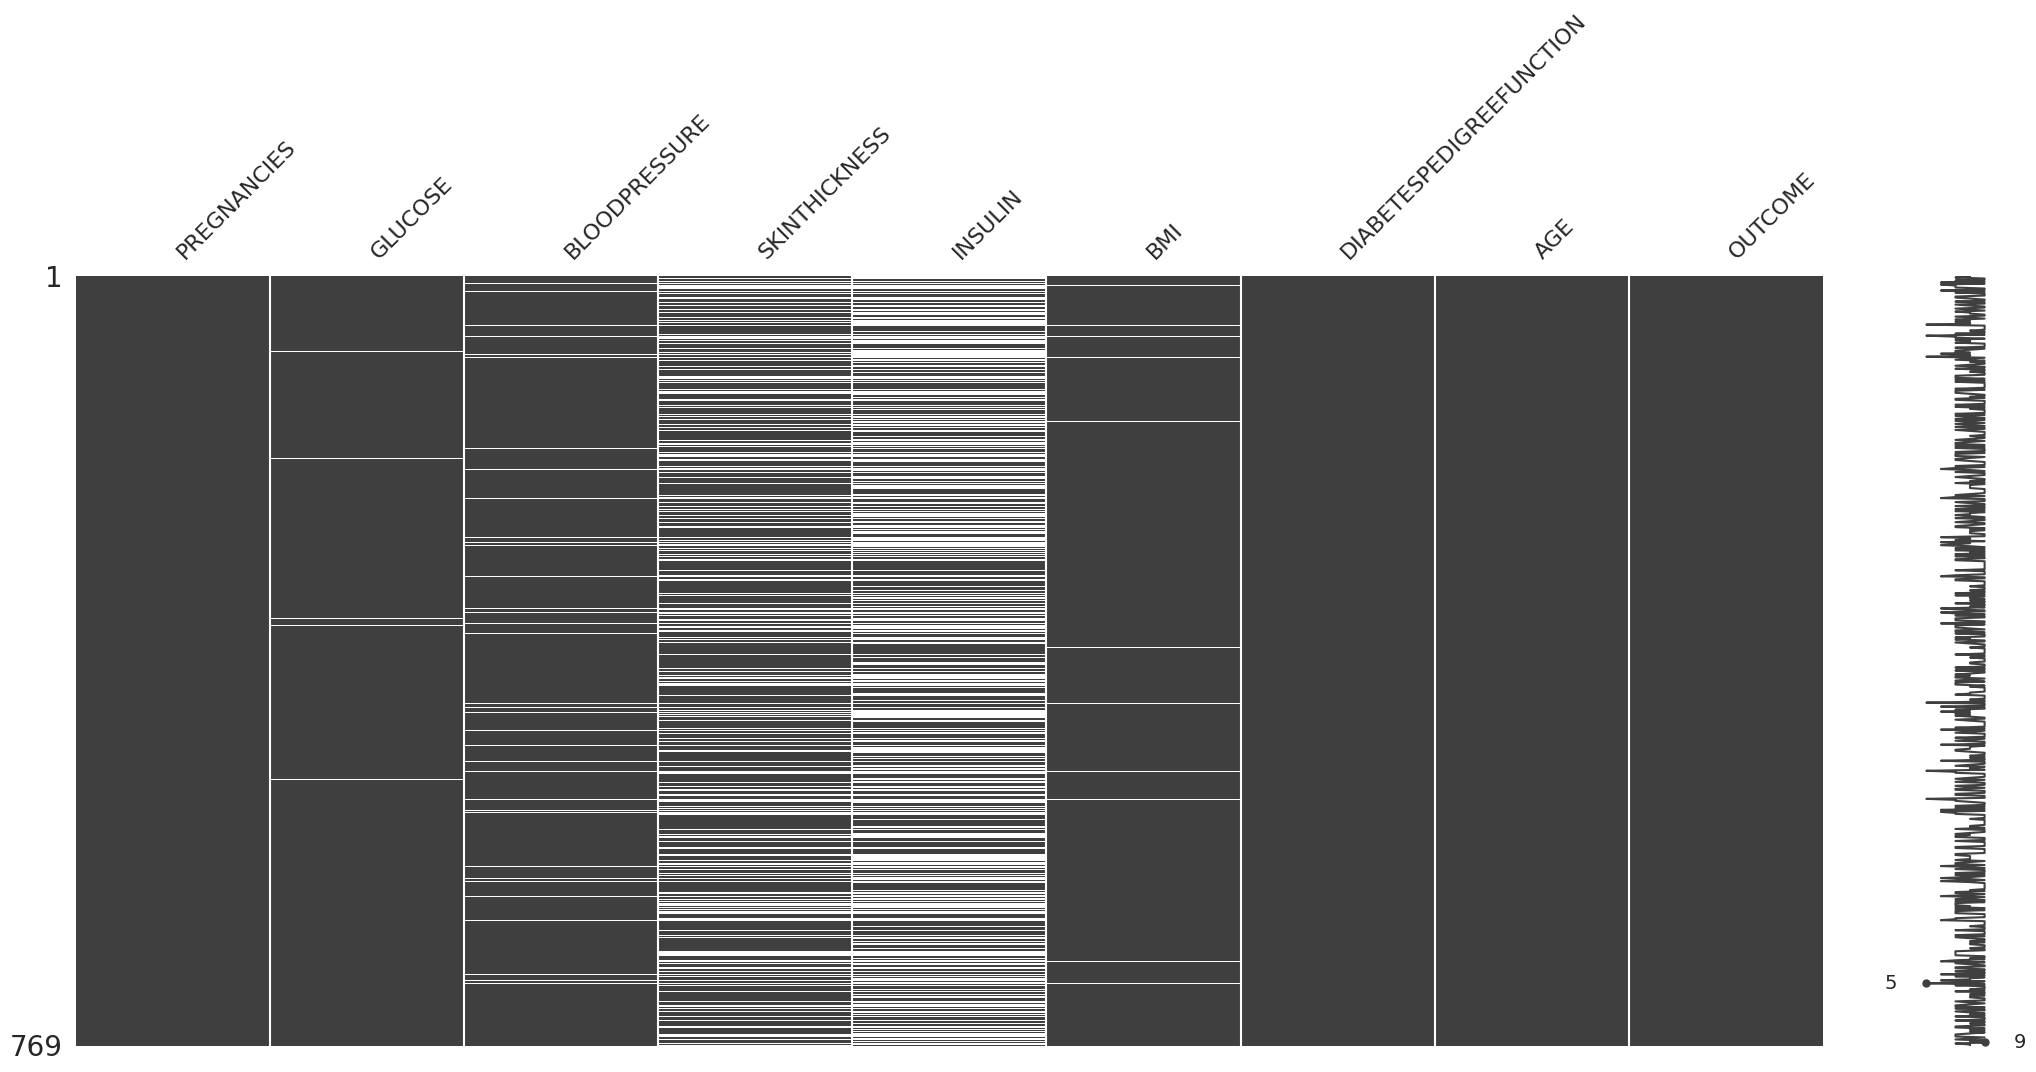

In [22]:
msno.matrix(df)
plt.show()

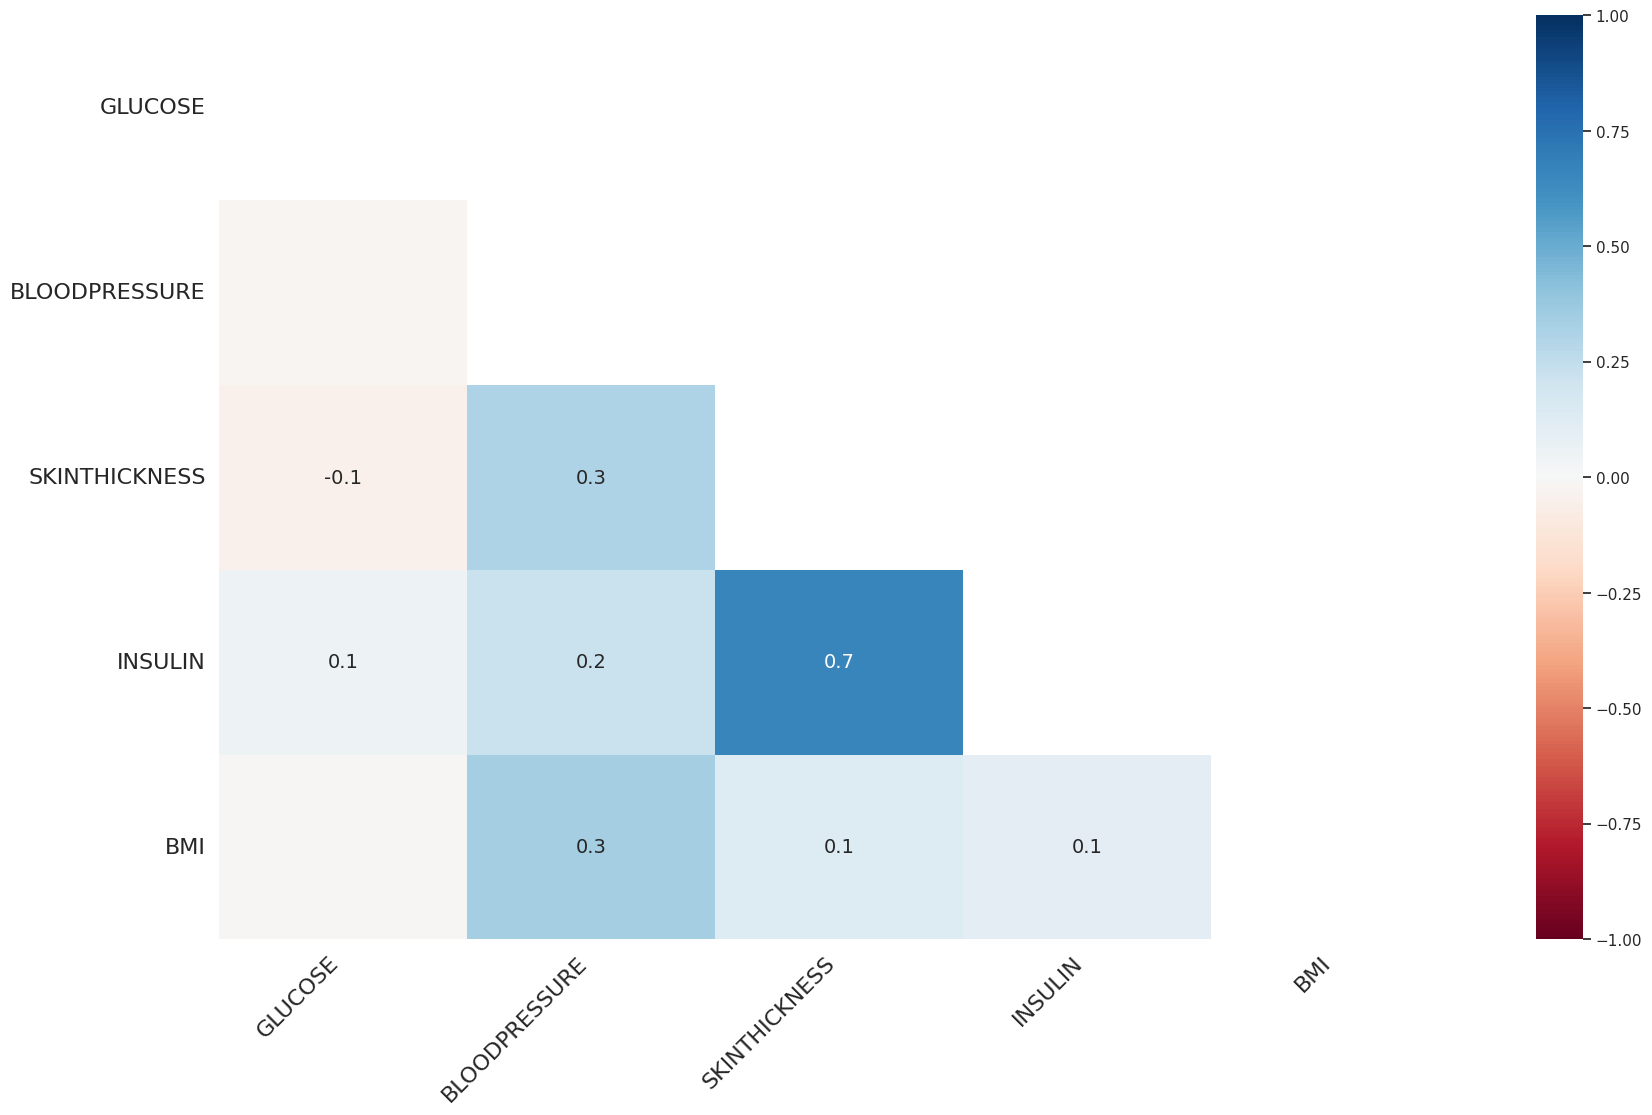

In [23]:
msno.heatmap(df)
plt.show()

In [24]:
def missing_values_table(dataframe, na_name=False):
   na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]


   n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
   ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
   missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
   print(missing_df, end="\n")


   if na_name:
       return na_columns


missing_values_table(df)
na_cols = missing_values_table(df, True)

               n_miss  ratio
INSULIN           374 48.630
SKINTHICKNESS     228 29.650
BLOODPRESSURE      35  4.550
BMI                11  1.430
GLUCOSE             5  0.650
               n_miss  ratio
INSULIN           374 48.630
SKINTHICKNESS     228 29.650
BLOODPRESSURE      35  4.550
BMI                11  1.430
GLUCOSE             5  0.650


In [25]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "OUTCOME", na_cols)

                 TARGET_MEAN  Count
GLUCOSE_NA_FLAG                    
0                      0.349    764
1                      0.400      5


                       TARGET_MEAN  Count
BLOODPRESSURE_NA_FLAG                    
0                            0.345    734
1                            0.457     35


                       TARGET_MEAN  Count
SKINTHICKNESS_NA_FLAG                    
0                            0.333    541
1                            0.390    228


                 TARGET_MEAN  Count
INSULIN_NA_FLAG                    
0                      0.332    395
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.352    758
1                  0.182     11




In [26]:
from sklearn.impute import KNNImputer
scaler = RobustScaler()
dff = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
dff.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,0.600,0.738,0.000,0.429,NaN,0.143,0.670,1.235,1.000
1,-0.400,-0.762,-0.375,0.000,NaN,-0.626,-0.052,0.118,0.000
2,1.000,1.571,-0.500,NaN,NaN,-0.989,0.788,0.176,1.000
3,-0.400,-0.667,-0.375,-0.429,-0.272,-0.462,-0.534,-0.471,0.000
4,-0.600,0.476,-2.000,0.429,0.377,1.187,5.018,0.235,1.000


In [27]:
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,0.600,0.738,0.000,0.429,2.414,0.143,0.670,1.235,1.000
1,-0.400,-0.762,-0.375,0.000,-0.525,-0.626,-0.052,0.118,0.000
2,1.000,1.571,-0.500,-0.071,0.611,-0.989,0.788,0.176,1.000
3,-0.400,-0.667,-0.375,-0.429,-0.272,-0.462,-0.534,-0.471,0.000
4,-0.600,0.476,-2.000,0.429,0.377,1.187,5.018,0.235,1.000


In [28]:
df = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6.000,148.000,72.000,35.000,400.200,33.600,0.627,50.000,1.000
1,1.000,85.000,66.000,29.000,65.200,26.600,0.351,31.000,0.000
2,8.000,183.000,64.000,28.000,194.600,23.300,0.672,32.000,1.000
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000


In [29]:
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [30]:
#AGE
# df["AGE"].describe()

# df.loc[(df['AGE'] < 29), 'NEW_AGE_CAT'] = 'very_young'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41), 'NEW_AGE_CAT'] = 'young'
# df.loc[(df['AGE'] >= 41), 'NEW_AGE_CAT'] = 'middle_aged'

# df["NEW_AGE_CAT"].value_counts()
# df["NEW_AGE_CAT"].value_counts(normalize=True)

# quick_sum = pd.DataFrame({"COUNT": df["NEW_AGE_CAT"].value_counts(),
#                             "RATIO": df["NEW_AGE_CAT"].value_counts() / len(df),
#                             "TARGET_MEAN": df.groupby("NEW_AGE_CAT")["OUTCOME"].mean()})
# df.head()


#BMI
# df["BMI"].describe()

# df.loc[(df['BMI'] < 19), 'BMI_CATEGORY'] = 'underweight'
# df.loc[(df['BMI'] >= 19) & (df['BMI'] < 25), 'BMI_CATEGORY'] = 'normal_weight'
# df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'BMI_CATEGORY'] = 'overweight'
# df.loc[(df['BMI'] >= 30), 'BMI_CATEGORY'] = 'obesity'

# BMI_Summary = df.groupby('BMI_CATEGORY')['OUTCOME'].mean()
# df.head()

#Glucose
df["GLUCOSE"].describe()
df.loc[(df['GLUCOSE'] <= 140), 'NEW_GLUCOSE'] = 'normal'
df.loc[(df['GLUCOSE'] > 140), 'NEW_GLUCOSE'] = 'high_risk'

#insulin
df['INSULIN_RESISTANCE'] = df['INSULIN'].apply(lambda x: 1 if x > 100 else 0)
Insulin_summary = df.groupby('INSULIN_RESISTANCE')['OUTCOME'].mean()
df.head()

#BMI & Age
# df.loc[(df['AGE'] < 29) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'very_young_underweight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'very_young_normal_weight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'very_young_overweight'
# df.loc[(df['AGE'] < 29) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'very_young_obesity'

# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'young_underweight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'young_normal_weight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'young_overweight'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'young_obesity'

# df.loc[(df['AGE'] >= 41) & (df['BMI'] < 19), 'NEW_AGE_BMI_CAT'] = 'middle_aged_underweight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 19) & (df['BMI'] < 25), 'NEW_AGE_BMI_CAT'] = 'middle_aged_normal_weight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_AGE_BMI_CAT'] = 'middle_aged_overweight'
# df.loc[(df['AGE'] >= 41) & (df['BMI'] >= 30), 'NEW_AGE_BMI_CAT'] = 'middle_aged_obesity'

# #glucose & Age
# df.loc[(df['AGE'] < 29) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'very_young_normal'
# df.loc[(df['AGE'] < 29) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'very_young_high_risk'

# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'young_normal'
# df.loc[(df['AGE'] >= 29) & (df['AGE'] < 41) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'young_high_risk'

# df.loc[(df['AGE'] >= 41) & (df['GLUCOSE'] <= 140), 'NEW_AGE_GLUCOSE_CAT'] = 'middle_aged_normal'
# df.loc[(df['AGE'] >= 41) & (df['GLUCOSE'] > 140), 'NEW_AGE_GLUCOSE_CAT'] = 'middle_aged_high_risk'

# #Glucose & Insulin
# df.loc[(df['INSULIN_RESISTANCE'] == 1) & (df['GLUCOSE'] <= 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'insulin_resistant_normal_glucose'
# df.loc[(df['INSULIN_RESISTANCE'] == 1) & (df['GLUCOSE'] > 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'insulin_resistant_high_risk_glucose'

# df.loc[(df['INSULIN_RESISTANCE'] == 0) & (df['GLUCOSE'] <= 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'no_insulin_resistance_normal_glucose'
# df.loc[(df['INSULIN_RESISTANCE'] == 0) & (df['GLUCOSE'] > 140), 'NEW_INSULIN_GLUCOSE_CAT'] = 'no_insulin_resistance_high_risk_glucose'

#insulin glucose interaction
df['INSULIN_GLUCOSE_INTERACTION'] = df['INSULIN'] * df['GLUCOSE']

CORRELATION_INS_GLU = df[['INSULIN', 'GLUCOSE', 'INSULIN_GLUCOSE_INTERACTION']].corr()
print(CORRELATION_INS_GLU)

#GLUCOSE Pregnancy interaction
df['GLUCOSE_PREGNANCIES_INTERACTION'] = df['GLUCOSE'] * df['PREGNANCIES']

CORRELATION_GLU_PRE = df[['INSULIN', 'PREGNANCIES', 'GLUCOSE_PREGNANCIES_INTERACTION']].corr()
print(CORRELATION_GLU_PRE)

#skinthickness glucose
df['SKINTHICKNESS_GLUCOSE_INTERACTION'] = df['SKINTHICKNESS'] * df['GLUCOSE']
CORRELATION_ST_GLU = df[['SKINTHICKNESS', 'GLUCOSE', 'SKINTHICKNESS_GLUCOSE_INTERACTION']].corr()
print(CORRELATION_GLU_PRE)


# #Pregnancies
# df["PREGNANCIES"].describe()
# correlation = df[['PREGNANCIES', 'OUTCOME']].corr()

# #BLOODPRESSURE * DIABETESPEDIGREEFUNCTION
# df["BP_DPF_INTERACTION"] =  df["BLOODPRESSURE"] * df["DIABETESPEDIGREEFUNCTION"]
# CORRELATION_BP_DPF = df[['BLOODPRESSURE', 'DIABETESPEDIGREEFUNCTION', 'BP_DPF_INTERACTION']].corr()
# print(CORRELATION_BP_DPF)

# #BMI * Glucose
# df["B_G_INTERACTION"] = df["BMI"] * df["GLUCOSE"]
# CORRELATION_BG = df[['BMI', 'GLUCOSE', 'B_G_INTERACTION']].corr()
# print(CORRELATION_BG)

#BMI * Insulin * Glucose Interaction
df["B_I_G_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"]
CORRELATION_BIG = df[['BMI', 'INSULIN', 'GLUCOSE', 'B_I_G_INTERACTION']].corr()
print(CORRELATION_BIG)

#BMI * Insulin * Glucose Interaction *Skinthickness
df["B_I_G_ST_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"] * df["SKINTHICKNESS"]
CORRELATION_BIGST = df[['BMI', 'INSULIN', 'GLUCOSE', 'SKINTHICKNESS', 'B_I_G_ST_INTERACTION']].corr()
print(CORRELATION_BIGST)

#BMI * Insulin * Glucose Interaction *Skinthickness * Bloodpressure
df["B_I_G_ST_BP_INTERACTION"] = df["BMI"] * df["INSULIN"] * df["GLUCOSE"] * df["SKINTHICKNESS"] * df["BLOODPRESSURE"]
CORRELATION_BIGSTBP = df[['BMI', 'INSULIN', 'GLUCOSE', 'SKINTHICKNESS', 'BLOODPRESSURE', 'B_I_G_ST_BP_INTERACTION']].corr()
print(CORRELATION_BIGSTBP)


cat_cols, num_cols, cat_but_car = grab_col_names(df)

                             INSULIN  GLUCOSE  INSULIN_GLUCOSE_INTERACTION
INSULIN                        1.000    0.597                        0.966
GLUCOSE                        0.597    1.000                        0.726
INSULIN_GLUCOSE_INTERACTION    0.966    0.726                        1.000
                                 INSULIN  PREGNANCIES  GLUCOSE_PREGNANCIES_INTERACTION
INSULIN                            1.000        0.111                            0.226
PREGNANCIES                        0.111        1.000                            0.941
GLUCOSE_PREGNANCIES_INTERACTION    0.226        0.941                            1.000
                                 INSULIN  PREGNANCIES  GLUCOSE_PREGNANCIES_INTERACTION
INSULIN                            1.000        0.111                            0.226
PREGNANCIES                        0.111        1.000                            0.941
GLUCOSE_PREGNANCIES_INTERACTION    0.226        0.941                            1.000
    

In [31]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,INSULIN_RESISTANCE,INSULIN_GLUCOSE_INTERACTION,GLUCOSE_PREGNANCIES_INTERACTION,SKINTHICKNESS_GLUCOSE_INTERACTION,B_I_G_INTERACTION,B_I_G_ST_INTERACTION,B_I_G_ST_BP_INTERACTION
0,6.000,148.000,72.000,35.000,400.200,33.600,0.627,50.000,1.000,high_risk,1,59229.600,888.000,5180.000,1990114.560,69654009.600,5015088691.200
1,1.000,85.000,66.000,29.000,65.200,26.600,0.351,31.000,0.000,normal,0,5542.000,85.000,2465.000,147417.200,4275098.800,282156520.800
2,8.000,183.000,64.000,28.000,194.600,23.300,0.672,32.000,1.000,high_risk,1,35611.800,1464.000,5124.000,829754.940,23233138.320,1486920852.480
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000,normal,0,8366.000,89.000,2047.000,235084.600,5406945.800,356858422.800
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000,normal,1,23016.000,0.000,4795.000,991989.600,34719636.000,1388785440.000


In [32]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)


In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "OUTCOME", cat_cols)

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.01)


Observations: 769
Variables: 17
cat_cols: 3
num_cols: 14
cat_but_car: 0
num_but_cat: 3
OUTCOME : 2
         COUNT  RATIO  TARGET_MEAN
OUTCOME                           
0.000      500  0.650        0.000
1.000      269  0.350        1.000


NEW_GLUCOSE : 2
             COUNT  RATIO  TARGET_MEAN
NEW_GLUCOSE                           
0              193  0.251        0.689
1              576  0.749        0.236


INSULIN_RESISTANCE : 2
                    COUNT  RATIO  TARGET_MEAN
INSULIN_RESISTANCE                           
0                     245  0.319        0.090
1                     524  0.681        0.471




In [34]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,INSULIN_RESISTANCE,INSULIN_GLUCOSE_INTERACTION,GLUCOSE_PREGNANCIES_INTERACTION,SKINTHICKNESS_GLUCOSE_INTERACTION,B_I_G_INTERACTION,B_I_G_ST_INTERACTION,B_I_G_ST_BP_INTERACTION
0,6.000,148.000,72.000,35.000,400.200,33.600,0.627,50.000,1.000,0,1,59229.600,888.000,5180.000,1990114.560,69654009.600,5015088691.200
1,1.000,85.000,66.000,29.000,65.200,26.600,0.351,31.000,0.000,1,0,5542.000,85.000,2465.000,147417.200,4275098.800,282156520.800
2,8.000,183.000,64.000,28.000,194.600,23.300,0.672,32.000,1.000,0,1,35611.800,1464.000,5124.000,829754.940,23233138.320,1486920852.480
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000,1,0,8366.000,89.000,2047.000,235084.600,5406945.800,356858422.800
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000,1,1,23016.000,0.000,4795.000,991989.600,34719636.000,1388785440.000


In [35]:
df.shape

(769, 17)

In [36]:
# def label_encoder(dataframe, binary_col):
#     labelencoder = LabelEncoder()
#     dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
#     return dataframe

# binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
#                and df[col].nunique() == 2]

# for col in binary_cols:
#     df = label_encoder(df, col)

# df.head()

In [37]:
scaler = RobustScaler()
df[num_cols] =  scaler.fit_transform(df[num_cols])
df[num_cols].head()

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,INSULIN_RESISTANCE,INSULIN_GLUCOSE_INTERACTION,GLUCOSE_PREGNANCIES_INTERACTION,SKINTHICKNESS_GLUCOSE_INTERACTION,B_I_G_INTERACTION,B_I_G_ST_INTERACTION,B_I_G_ST_BP_INTERACTION
0,0.600,0.738,0.000,0.500,2.659,0.165,0.670,1.235,1.000,0,1,2.579,0.897,0.814,2.576,2.567,2.439
1,-0.400,-0.762,-0.375,0.000,-0.625,-0.604,-0.052,0.118,0.000,1,0,-0.568,-0.415,-0.400,-0.596,-0.464,-0.450
2,1.000,1.571,-0.500,-0.083,0.643,-0.967,0.788,0.176,1.000,0,1,1.195,1.838,0.789,0.579,0.415,0.285
3,-0.400,-0.667,-0.375,-0.500,-0.343,-0.440,-0.534,-0.471,0.000,1,0,-0.402,-0.408,-0.587,-0.445,-0.411,-0.405
4,-0.600,0.476,-2.000,0.500,0.382,1.209,5.018,0.235,1.000,1,1,0.457,-0.554,0.642,0.858,0.948,0.225


In [38]:
df.shape

(769, 17)

In [39]:
y = df["OUTCOME"]


X = df.drop(["OUTCOME"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)


from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(max_depth=8, random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X, y, cv=15, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")
accuracy_score(y_pred, y_test)

Mean Cross-Validation Accuracy: 0.7737305178481652


0.7357512953367875

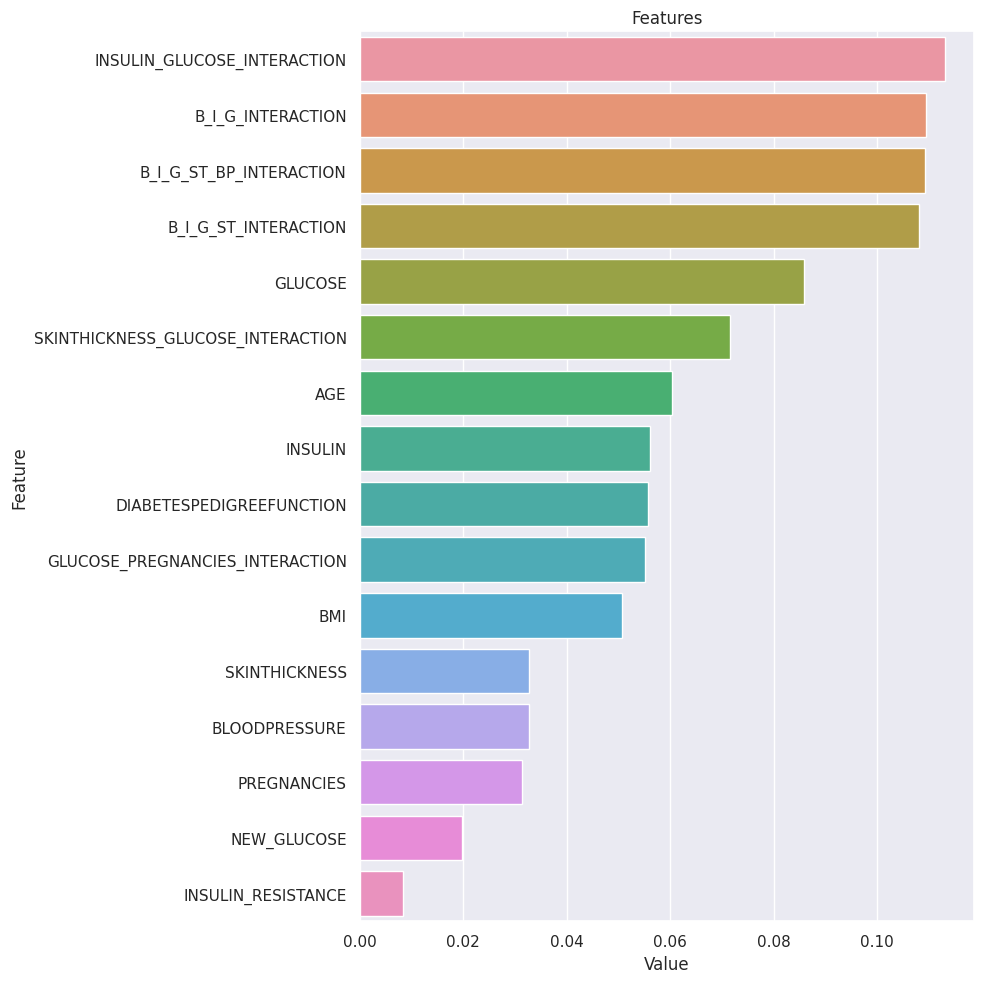

In [40]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)